In [2]:
# Dependencies and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import gmaps
import os
import json 
import scipy.stats as st
from sklearn.linear_model import LinearRegression
import urllib
from scipy.stats import linregress
import time
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# File to Load
file_to_load = "Resources/BRFSS__Table_of_Overweight_and_Obesity__BMI_.csv"

# Read Obesity CSV and store into Pandas data frame
obesity_df_full = pd.read_csv(file_to_load)
obesity_df_full.head(10)

,Year,Locationabbr,Locationdesc,Class,Topic,Question,Response,Break_Out,Break_Out_Category,Sample_Size,...,Data_Value_Footnote,DataSource,ClassId,TopicId,LocationID,BreakoutID,BreakOutCategoryID,QuestionID,ResponseID,GeoLocation
0,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Overweight (BMI 25.0-29.9),"Black, non-Hispanic",Race/Ethnicity,22,...,Prevalence estimate not available if the unwei...,BRFSS,CLASS14,TOPIC09,2,RACE02,CAT4,_BMI5CAT,RESP040,"(64.84507995700051, -147.72205903599973)"
1,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Underweight (BMI 12.0-18.4),"Multiracial, non-Hispanic",Race/Ethnicity,2,...,Prevalence estimate not available if the unwei...,BRFSS,CLASS14,TOPIC09,2,RACE07,CAT4,_BMI5CAT,RESP042,"(64.84507995700051, -147.72205903599973)"
2,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Obese (BMI 30.0 - 99.8),H.S. or G.E.D.,Education Attained,239,...,NaN,BRFSS,CLASS14,TOPIC09,2,EDUCA2,CAT5,_BMI5CAT,RESP039,"(64.84507995700051, -147.72205903599973)"
3,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Overweight (BMI 25.0-29.9),35-44,Age Group,151,...,NaN,BRFSS,CLASS14,TOPIC09,2,AGE03,CAT3,_BMI5CAT,RESP040,"(64.84507995700051, -147.72205903599973)"
4,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Normal Weight (BMI 18.5-24.9),"$15,000-$24,999",Household Income,95,...,NaN,BRFSS,CLASS14,TOPIC09,2,INCOME2,CAT6,_BMI5CAT,RESP041,"(64.84507995700051, -147.72205903599973)"
5,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Obese (BMI 30.0 - 99.8),65+,Age Group,261,...,NaN,BRFSS,CLASS14,TOPIC09,2,AGE09,CAT3,_BMI5CAT,RESP039,"(64.84507995700051, -147.72205903599973)"
6,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Overweight (BMI 25.0-29.9),"Less than $15,000",Household Income,49,...,NaN,BRFSS,CLASS14,TOPIC09,2,INCOME1,CAT6,_BMI5CAT,RESP040,"(64.84507995700051, -147.72205903599973)"
7,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Normal Weight (BMI 18.5-24.9),"$25,000-$34,999",Household Income,48,...,NaN,BRFSS,CLASS14,TOPIC09,2,INCOME3,CAT6,_BMI5CAT,RESP041,"(64.84507995700051, -147.72205903599973)"
8,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Underweight (BMI 12.0-18.4),"American Indian or Alaskan Native, non-Hispanic",Race/Ethnicity,5,...,Prevalence estimate not available if the unwei...,BRFSS,CLASS14,TOPIC09,2,RACE03,CAT4,_BMI5CAT,RESP042,"(64.84507995700051, -147.72205903599973)"
9,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Overweight (BMI 25.0-29.9),"Other, non-Hispanic",Race/Ethnicity,19,...,Prevalence estimate not available if the unwei...,BRFSS,CLASS14,TOPIC09,2,RACE06,CAT4,_BMI5CAT,RESP040,"(64.84507995700051, -147.72205903599973)"


In [4]:
# Extract Columns that will be used in analysis
reduced_obesity_df = obesity_df_full.loc[:, ["Year", "Locationabbr", "Response", "Break_Out", "Break_Out_Category", 
                                             "Sample_Size", "BreakoutID", "GeoLocation"]]
reduced_obesity_df.head()



,Year,Locationabbr,Response,Break_Out,Break_Out_Category,Sample_Size,BreakoutID,GeoLocation
0,2019,AK,Overweight (BMI 25.0-29.9),"Black, non-Hispanic",Race/Ethnicity,22,RACE02,"(64.84507995700051, -147.72205903599973)"
1,2019,AK,Underweight (BMI 12.0-18.4),"Multiracial, non-Hispanic",Race/Ethnicity,2,RACE07,"(64.84507995700051, -147.72205903599973)"
2,2019,AK,Obese (BMI 30.0 - 99.8),H.S. or G.E.D.,Education Attained,239,EDUCA2,"(64.84507995700051, -147.72205903599973)"
3,2019,AK,Overweight (BMI 25.0-29.9),35-44,Age Group,151,AGE03,"(64.84507995700051, -147.72205903599973)"
4,2019,AK,Normal Weight (BMI 18.5-24.9),"$15,000-$24,999",Household Income,95,INCOME2,"(64.84507995700051, -147.72205903599973)"


In [5]:
# Rename columns for clarity
reduced_obesity_df = reduced_obesity_df.rename(columns={"Locationabbr": "State", 
                                                        "Response": "BMI Range", "Break_Out": "Class", 
                                                        "Break_Out_Category": "Class Category", 
                                                        "Sample_Size": "Number of Respondents",
                                                        "BreakoutID": "Class ID"})

reduced_obesity_df.head()

,Year,State,BMI Range,Class,Class Category,Number of Respondents,Class ID,GeoLocation
0,2019,AK,Overweight (BMI 25.0-29.9),"Black, non-Hispanic",Race/Ethnicity,22,RACE02,"(64.84507995700051, -147.72205903599973)"
1,2019,AK,Underweight (BMI 12.0-18.4),"Multiracial, non-Hispanic",Race/Ethnicity,2,RACE07,"(64.84507995700051, -147.72205903599973)"
2,2019,AK,Obese (BMI 30.0 - 99.8),H.S. or G.E.D.,Education Attained,239,EDUCA2,"(64.84507995700051, -147.72205903599973)"
3,2019,AK,Overweight (BMI 25.0-29.9),35-44,Age Group,151,AGE03,"(64.84507995700051, -147.72205903599973)"
4,2019,AK,Normal Weight (BMI 18.5-24.9),"$15,000-$24,999",Household Income,95,INCOME2,"(64.84507995700051, -147.72205903599973)"


In [6]:
# Reorder columns for clairty
reduced_obesity_df = reduced_obesity_df[['Year', 'State', 'Number of Respondents', 
                                         'BMI Range', 'Class', 'Class Category', 'Class ID', 'GeoLocation']]
reduced_obesity_df.head()

,Year,State,Number of Respondents,BMI Range,Class,Class Category,Class ID,GeoLocation
0,2019,AK,22,Overweight (BMI 25.0-29.9),"Black, non-Hispanic",Race/Ethnicity,RACE02,"(64.84507995700051, -147.72205903599973)"
1,2019,AK,2,Underweight (BMI 12.0-18.4),"Multiracial, non-Hispanic",Race/Ethnicity,RACE07,"(64.84507995700051, -147.72205903599973)"
2,2019,AK,239,Obese (BMI 30.0 - 99.8),H.S. or G.E.D.,Education Attained,EDUCA2,"(64.84507995700051, -147.72205903599973)"
3,2019,AK,151,Overweight (BMI 25.0-29.9),35-44,Age Group,AGE03,"(64.84507995700051, -147.72205903599973)"
4,2019,AK,95,Normal Weight (BMI 18.5-24.9),"$15,000-$24,999",Household Income,INCOME2,"(64.84507995700051, -147.72205903599973)"


In [7]:
# Split GeoLocation into lat and lng for loop
new_column = reduced_obesity_df["GeoLocation"].str.split(",", n = 1, expand = True) 
reduced_obesity_df["Lat"]= new_column[0] 
reduced_obesity_df["Lng"]= new_column[1] 
reduced_obesity_df.head()

,Year,State,Number of Respondents,BMI Range,Class,Class Category,Class ID,GeoLocation,Lat,Lng
0,2019,AK,22,Overweight (BMI 25.0-29.9),"Black, non-Hispanic",Race/Ethnicity,RACE02,"(64.84507995700051, -147.72205903599973)",(64.84507995700051,-147.72205903599973)
1,2019,AK,2,Underweight (BMI 12.0-18.4),"Multiracial, non-Hispanic",Race/Ethnicity,RACE07,"(64.84507995700051, -147.72205903599973)",(64.84507995700051,-147.72205903599973)
2,2019,AK,239,Obese (BMI 30.0 - 99.8),H.S. or G.E.D.,Education Attained,EDUCA2,"(64.84507995700051, -147.72205903599973)",(64.84507995700051,-147.72205903599973)
3,2019,AK,151,Overweight (BMI 25.0-29.9),35-44,Age Group,AGE03,"(64.84507995700051, -147.72205903599973)",(64.84507995700051,-147.72205903599973)
4,2019,AK,95,Normal Weight (BMI 18.5-24.9),"$15,000-$24,999",Household Income,INCOME2,"(64.84507995700051, -147.72205903599973)",(64.84507995700051,-147.72205903599973)


In [8]:
# Remove unwanted characters from the Lat and Lng Columns
reduced_obesity_df['Lat'] = reduced_obesity_df['Lat'].str.replace('(', '')
reduced_obesity_df['Lng'] = reduced_obesity_df['Lng'].str.replace(')', '')
reduced_obesity_df.head()

,Year,State,Number of Respondents,BMI Range,Class,Class Category,Class ID,GeoLocation,Lat,Lng
0,2019,AK,22,Overweight (BMI 25.0-29.9),"Black, non-Hispanic",Race/Ethnicity,RACE02,"(64.84507995700051, -147.72205903599973)",64.84507995700051,-147.72205903599973
1,2019,AK,2,Underweight (BMI 12.0-18.4),"Multiracial, non-Hispanic",Race/Ethnicity,RACE07,"(64.84507995700051, -147.72205903599973)",64.84507995700051,-147.72205903599973
2,2019,AK,239,Obese (BMI 30.0 - 99.8),H.S. or G.E.D.,Education Attained,EDUCA2,"(64.84507995700051, -147.72205903599973)",64.84507995700051,-147.72205903599973
3,2019,AK,151,Overweight (BMI 25.0-29.9),35-44,Age Group,AGE03,"(64.84507995700051, -147.72205903599973)",64.84507995700051,-147.72205903599973
4,2019,AK,95,Normal Weight (BMI 18.5-24.9),"$15,000-$24,999",Household Income,INCOME2,"(64.84507995700051, -147.72205903599973)",64.84507995700051,-147.72205903599973


In [9]:
# Remove Geolocation
reduced_obesity_df.drop(columns=['GeoLocation'])

,Year,State,Number of Respondents,BMI Range,Class,Class Category,Class ID,Lat,Lng
0,2019,AK,22,Overweight (BMI 25.0-29.9),"Black, non-Hispanic",Race/Ethnicity,RACE02,64.84507995700051,-147.72205903599973
1,2019,AK,2,Underweight (BMI 12.0-18.4),"Multiracial, non-Hispanic",Race/Ethnicity,RACE07,64.84507995700051,-147.72205903599973
2,2019,AK,239,Obese (BMI 30.0 - 99.8),H.S. or G.E.D.,Education Attained,EDUCA2,64.84507995700051,-147.72205903599973
3,2019,AK,151,Overweight (BMI 25.0-29.9),35-44,Age Group,AGE03,64.84507995700051,-147.72205903599973
4,2019,AK,95,Normal Weight (BMI 18.5-24.9),"$15,000-$24,999",Household Income,INCOME2,64.84507995700051,-147.72205903599973
...,...,...,...,...,...,...,...,...,...
47069,2011,WY,13,Underweight (BMI 12.0-18.4),"$35,000-$49,999",Household Income,INCOME4,43.235541343,-108.109830353
47070,2011,WY,689,Obese (BMI 30.0 - 99.8),"$50,000+",Household Income,INCOME5,43.235541343,-108.109830353
47071,2011,WY,"1,116",Overweight (BMI 25.0-29.9),"$50,000+",Household Income,INCOME5,43.235541343,-108.109830353
47072,2011,WY,971,Normal Weight (BMI 18.5-24.9),"$50,000+",Household Income,INCOME5,43.235541343,-108.109830353


In [10]:
# Extract Columns that will be used in analysis
reduced_obesity_df1 = obesity_df_full.loc[:, ["Year", "Locationabbr", "Response", "Break_Out", "Break_Out_Category", 
                                             "Data_value", "Confidence_limit_Low", "Confidence_limit_High",
                                              "Data_Value_Footnote_Symbol"]]
reduced_obesity_df1.head()

,Year,Locationabbr,Response,Break_Out,Break_Out_Category,Data_value,Confidence_limit_Low,Confidence_limit_High,Data_Value_Footnote_Symbol
0,2019,AK,Overweight (BMI 25.0-29.9),"Black, non-Hispanic",Race/Ethnicity,NaN,NaN,NaN,*
1,2019,AK,Underweight (BMI 12.0-18.4),"Multiracial, non-Hispanic",Race/Ethnicity,NaN,NaN,NaN,*
2,2019,AK,Obese (BMI 30.0 - 99.8),H.S. or G.E.D.,Education Attained,27.32,22.50,32.14,NaN
3,2019,AK,Overweight (BMI 25.0-29.9),35-44,Age Group,38.39,31.65,45.13,NaN
4,2019,AK,Normal Weight (BMI 18.5-24.9),"$15,000-$24,999",Household Income,35.23,25.61,44.85,NaN


In [11]:
# Rename columns for clarity
reduced_obesity_df1 = reduced_obesity_df1.rename(columns={"Locationabbr": "State", 
                                                        "Response": "BMI", "Break_Out": "Class", 
                                                        "Break_Out_Category": "Class Category", 
                                                        "Data_value": "Data Value",
                                                        "Confidence_limit_Low": "Lower Limit",
                                                        "Confidence_limit_High":"Higher Limit",
                                                         "Data_Value_Footnote_Symbol":"Footnote"})

reduced_obesity_df1.head()

,Year,State,BMI,Class,Class Category,Data Value,Lower Limit,Higher Limit,Footnote
0,2019,AK,Overweight (BMI 25.0-29.9),"Black, non-Hispanic",Race/Ethnicity,NaN,NaN,NaN,*
1,2019,AK,Underweight (BMI 12.0-18.4),"Multiracial, non-Hispanic",Race/Ethnicity,NaN,NaN,NaN,*
2,2019,AK,Obese (BMI 30.0 - 99.8),H.S. or G.E.D.,Education Attained,27.32,22.50,32.14,NaN
3,2019,AK,Overweight (BMI 25.0-29.9),35-44,Age Group,38.39,31.65,45.13,NaN
4,2019,AK,Normal Weight (BMI 18.5-24.9),"$15,000-$24,999",Household Income,35.23,25.61,44.85,NaN


In [12]:
step_df = reduced_obesity_df1[reduced_obesity_df1['Footnote'] == "*"]
step_df

,Year,State,BMI,Class,Class Category,Data Value,Lower Limit,Higher Limit,Footnote
0,2019,AK,Overweight (BMI 25.0-29.9),"Black, non-Hispanic",Race/Ethnicity,NaN,NaN,NaN,*
1,2019,AK,Underweight (BMI 12.0-18.4),"Multiracial, non-Hispanic",Race/Ethnicity,NaN,NaN,NaN,*
8,2019,AK,Underweight (BMI 12.0-18.4),"American Indian or Alaskan Native, non-Hispanic",Race/Ethnicity,NaN,NaN,NaN,*
9,2019,AK,Overweight (BMI 25.0-29.9),"Other, non-Hispanic",Race/Ethnicity,NaN,NaN,NaN,*
10,2019,AK,Underweight (BMI 12.0-18.4),H.S. or G.E.D.,Education Attained,NaN,NaN,NaN,*
...,...,...,...,...,...,...,...,...,...
47037,2011,WY,Underweight (BMI 12.0-18.4),"Multiracial, non-Hispanic",Race/Ethnicity,NaN,NaN,NaN,*
47041,2011,WY,Underweight (BMI 12.0-18.4),Less than H.S.,Education Attained,NaN,NaN,NaN,*
47053,2011,WY,Underweight (BMI 12.0-18.4),College graduate,Education Attained,NaN,NaN,NaN,*
47065,2011,WY,Underweight (BMI 12.0-18.4),"$25,000-$34,999",Household Income,NaN,NaN,NaN,*


In [13]:
clean_data = reduced_obesity_df1.drop(step_df.index, inplace = False) 
clean_data

,Year,State,BMI,Class,Class Category,Data Value,Lower Limit,Higher Limit,Footnote
2,2019,AK,Obese (BMI 30.0 - 99.8),H.S. or G.E.D.,Education Attained,27.32,22.50,32.14,NaN
3,2019,AK,Overweight (BMI 25.0-29.9),35-44,Age Group,38.39,31.65,45.13,NaN
4,2019,AK,Normal Weight (BMI 18.5-24.9),"$15,000-$24,999",Household Income,35.23,25.61,44.85,NaN
5,2019,AK,Obese (BMI 30.0 - 99.8),65+,Age Group,30.22,25.44,35.00,NaN
6,2019,AK,Overweight (BMI 25.0-29.9),"Less than $15,000",Household Income,31.51,17.59,45.43,NaN
...,...,...,...,...,...,...,...,...,...
47068,2011,WY,Normal Weight (BMI 18.5-24.9),"$35,000-$49,999",Household Income,36.40,31.60,41.30,NaN
47070,2011,WY,Obese (BMI 30.0 - 99.8),"$50,000+",Household Income,24.50,22.10,26.80,NaN
47071,2011,WY,Overweight (BMI 25.0-29.9),"$50,000+",Household Income,40.70,38.00,43.30,NaN
47072,2011,WY,Normal Weight (BMI 18.5-24.9),"$50,000+",Household Income,33.90,31.40,36.40,NaN


In [14]:
pd.isnull(reduced_obesity_df1.iloc[:,5])

0         True
1         True
2        False
3        False
4        False
         ...  
47069     True
47070    False
47071    False
47072    False
47073    False
Name: Data Value, Length: 47074, dtype: bool

In [15]:
clean_data = clean_data.drop('Footnote', axis=1,inplace=False)
clean_data

,Year,State,BMI,Class,Class Category,Data Value,Lower Limit,Higher Limit
2,2019,AK,Obese (BMI 30.0 - 99.8),H.S. or G.E.D.,Education Attained,27.32,22.50,32.14
3,2019,AK,Overweight (BMI 25.0-29.9),35-44,Age Group,38.39,31.65,45.13
4,2019,AK,Normal Weight (BMI 18.5-24.9),"$15,000-$24,999",Household Income,35.23,25.61,44.85
5,2019,AK,Obese (BMI 30.0 - 99.8),65+,Age Group,30.22,25.44,35.00
6,2019,AK,Overweight (BMI 25.0-29.9),"Less than $15,000",Household Income,31.51,17.59,45.43
...,...,...,...,...,...,...,...,...
47068,2011,WY,Normal Weight (BMI 18.5-24.9),"$35,000-$49,999",Household Income,36.40,31.60,41.30
47070,2011,WY,Obese (BMI 30.0 - 99.8),"$50,000+",Household Income,24.50,22.10,26.80
47071,2011,WY,Overweight (BMI 25.0-29.9),"$50,000+",Household Income,40.70,38.00,43.30
47072,2011,WY,Normal Weight (BMI 18.5-24.9),"$50,000+",Household Income,33.90,31.40,36.40


In [16]:
obese_df = clean_data.loc[(clean_data['BMI'] == 'Obese (BMI 30.0 - 99.8)')| (clean_data['BMI'] == 'Obese (bmi 30.0 - 99.8)')]
obese_df

,Year,State,BMI,Class,Class Category,Data Value,Lower Limit,Higher Limit
2,2019,AK,Obese (BMI 30.0 - 99.8),H.S. or G.E.D.,Education Attained,27.32,22.50,32.14
5,2019,AK,Obese (BMI 30.0 - 99.8),65+,Age Group,30.22,25.44,35.00
13,2019,AK,Obese (BMI 30.0 - 99.8),Female,Gender,30.56,26.27,34.85
17,2019,AK,Obese (BMI 30.0 - 99.8),18-24,Age Group,15.44,7.87,23.01
24,2019,AK,Obese (BMI 30.0 - 99.8),"$50,000+",Household Income,29.74,25.96,33.52
...,...,...,...,...,...,...,...,...
47054,2011,WY,Obese (BMI 30.0 - 99.8),"Less than $15,000",Household Income,32.20,26.40,38.10
47058,2011,WY,Obese (BMI 30.0 - 99.8),"$15,000-$24,999",Household Income,24.60,20.60,28.70
47062,2011,WY,Obese (BMI 30.0 - 99.8),"$25,000-$34,999",Household Income,23.70,19.00,28.40
47066,2011,WY,Obese (BMI 30.0 - 99.8),"$35,000-$49,999",Household Income,25.50,21.40,29.60


In [17]:
clctg_df = obese_df.loc[obese_df['Class Category'] == 'Age Group']
clctg_df

,Year,State,BMI,Class,Class Category,Data Value,Lower Limit,Higher Limit
5,2019,AK,Obese (BMI 30.0 - 99.8),65+,Age Group,30.22,25.44,35.00
17,2019,AK,Obese (BMI 30.0 - 99.8),18-24,Age Group,15.44,7.87,23.01
43,2019,AK,Obese (BMI 30.0 - 99.8),45-54,Age Group,42.30,35.19,49.41
87,2019,AK,Obese (BMI 30.0 - 99.8),35-44,Age Group,35.86,28.61,43.11
88,2019,AK,Obese (BMI 30.0 - 99.8),55-64,Age Group,30.78,25.35,36.21
...,...,...,...,...,...,...,...,...
46998,2011,WY,Obese (BMI 30.0 - 99.8),25-34,Age Group,25.10,21.40,28.90
47002,2011,WY,Obese (BMI 30.0 - 99.8),35-44,Age Group,28.70,24.80,32.70
47006,2011,WY,Obese (BMI 30.0 - 99.8),45-54,Age Group,29.30,25.40,33.10
47010,2011,WY,Obese (BMI 30.0 - 99.8),55-64,Age Group,31.80,28.10,35.40


In [40]:
yr2019 = clctg_df.loc[clctg_df['Year'] == 2019]
yr2019

,Year,State,BMI,Class,Class Category,Data Value,Lower Limit,Higher Limit
5,2019,AK,Obese (BMI 30.0 - 99.8),65+,Age Group,30.22,25.44,35.00
17,2019,AK,Obese (BMI 30.0 - 99.8),18-24,Age Group,15.44,7.87,23.01
43,2019,AK,Obese (BMI 30.0 - 99.8),45-54,Age Group,42.30,35.19,49.41
87,2019,AK,Obese (BMI 30.0 - 99.8),35-44,Age Group,35.86,28.61,43.11
88,2019,AK,Obese (BMI 30.0 - 99.8),55-64,Age Group,30.78,25.35,36.21
...,...,...,...,...,...,...,...,...
5351,2019,WY,Obese (BMI 30.0 - 99.8),45-54,Age Group,37.19,31.86,42.52
5365,2019,WY,Obese (BMI 30.0 - 99.8),65+,Age Group,28.72,25.92,31.52
5368,2019,WY,Obese (BMI 30.0 - 99.8),18-24,Age Group,20.63,13.73,27.53
5386,2019,WY,Obese (BMI 30.0 - 99.8),55-64,Age Group,32.52,28.56,36.48


In [41]:
cls_df = yr2019.loc[yr2019['Class'] == '65+']
cls_df

,Year,State,BMI,Class,Class Category,Data Value,Lower Limit,Higher Limit
5,2019,AK,Obese (BMI 30.0 - 99.8),65+,Age Group,30.22,25.44,35.00
107,2019,AL,Obese (BMI 30.0 - 99.8),65+,Age Group,31.30,28.97,33.63
309,2019,AR,Obese (BMI 30.0 - 99.8),65+,Age Group,32.43,29.98,34.88
397,2019,AZ,Obese (BMI 30.0 - 99.8),65+,Age Group,25.71,23.36,28.06
504,2019,CA,Obese (BMI 30.0 - 99.8),65+,Age Group,23.30,21.26,25.34
550,2019,CO,Obese (BMI 30.0 - 99.8),65+,Age Group,24.17,22.37,25.97
693,2019,CT,Obese (BMI 30.0 - 99.8),65+,Age Group,28.23,26.17,30.29
787,2019,DC,Obese (BMI 30.0 - 99.8),65+,Age Group,25.85,22.32,29.38
882,2019,DE,Obese (BMI 30.0 - 99.8),65+,Age Group,32.57,29.04,36.10
1035,2019,FL,Obese (BMI 30.0 - 99.8),65+,Age Group,27.58,25.38,29.78


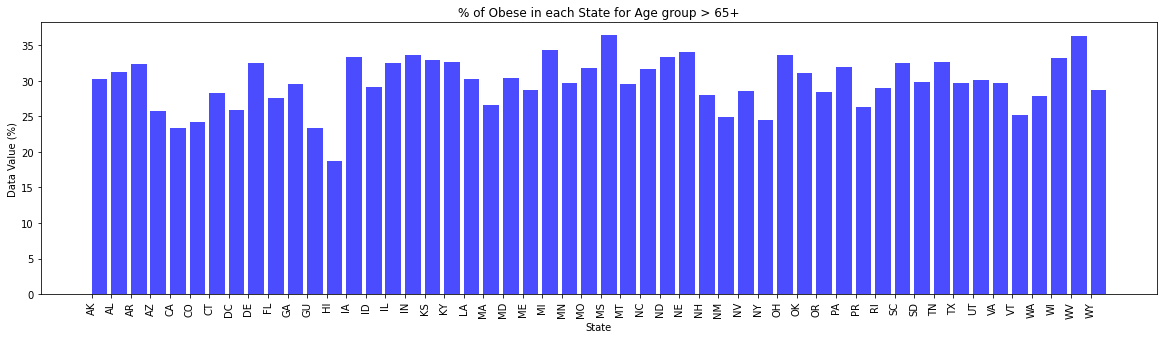

In [42]:
f = plt.figure() 
f.set_figwidth(20) 
f.set_figheight(5)
plt.bar(cls_df['State'],cls_df['Data Value'], color='b', alpha=0.7, align='edge')
plt.xticks(rotation='vertical')
plt.xlabel("State")
plt.ylabel("Data Value (%)")
plt.title('% of Obese in each State for Age group > 65+')
plt.show()

In [43]:
cls_df1 = yr2019.loc[yr2019['Class'] == '55-64']
cls_df1

,Year,State,BMI,Class,Class Category,Data Value,Lower Limit,Higher Limit
88,2019,AK,Obese (BMI 30.0 - 99.8),55-64,Age Group,30.78,25.35,36.21
150,2019,AL,Obese (BMI 30.0 - 99.8),55-64,Age Group,41.16,37.97,44.35
265,2019,AR,Obese (BMI 30.0 - 99.8),55-64,Age Group,40.62,36.80,44.44
325,2019,AZ,Obese (BMI 30.0 - 99.8),55-64,Age Group,38.47,34.35,42.59
480,2019,CA,Obese (BMI 30.0 - 99.8),55-64,Age Group,29.82,27.15,32.49
568,2019,CO,Obese (BMI 30.0 - 99.8),55-64,Age Group,27.80,25.39,30.21
672,2019,CT,Obese (BMI 30.0 - 99.8),55-64,Age Group,32.48,29.78,35.18
809,2019,DC,Obese (BMI 30.0 - 99.8),55-64,Age Group,40.51,34.71,46.31
913,2019,DE,Obese (BMI 30.0 - 99.8),55-64,Age Group,40.10,35.40,44.80
982,2019,FL,Obese (BMI 30.0 - 99.8),55-64,Age Group,31.29,27.64,34.94


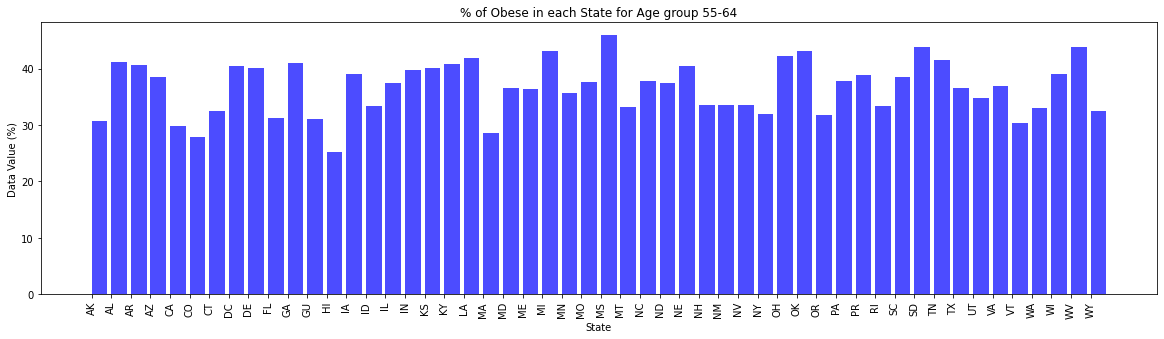

In [44]:
f = plt.figure() 
f.set_figwidth(20) 
f.set_figheight(5)
plt.bar(cls_df1['State'],cls_df1['Data Value'], color='b', alpha=0.7, align='edge')
plt.xticks(rotation='vertical')
plt.xlabel("State")
plt.ylabel("Data Value (%)")
plt.title('% of Obese in each State for Age group 55-64')
plt.show()

In [45]:
cls_df2 = yr2019.loc[yr2019['Class'] == '45-54']
cls_df2

,Year,State,BMI,Class,Class Category,Data Value,Lower Limit,Higher Limit
43,2019,AK,Obese (BMI 30.0 - 99.8),45-54,Age Group,42.30,35.19,49.41
142,2019,AL,Obese (BMI 30.0 - 99.8),45-54,Age Group,41.49,37.79,45.19
226,2019,AR,Obese (BMI 30.0 - 99.8),45-54,Age Group,43.71,38.93,48.49
364,2019,AZ,Obese (BMI 30.0 - 99.8),45-54,Age Group,39.86,35.10,44.62
475,2019,CA,Obese (BMI 30.0 - 99.8),45-54,Age Group,33.65,30.77,36.53
580,2019,CO,Obese (BMI 30.0 - 99.8),45-54,Age Group,27.43,24.76,30.10
650,2019,CT,Obese (BMI 30.0 - 99.8),45-54,Age Group,33.14,30.00,36.28
807,2019,DC,Obese (BMI 30.0 - 99.8),45-54,Age Group,28.79,23.58,34.00
892,2019,DE,Obese (BMI 30.0 - 99.8),45-54,Age Group,40.46,35.05,45.87
1005,2019,FL,Obese (BMI 30.0 - 99.8),45-54,Age Group,33.84,29.39,38.29


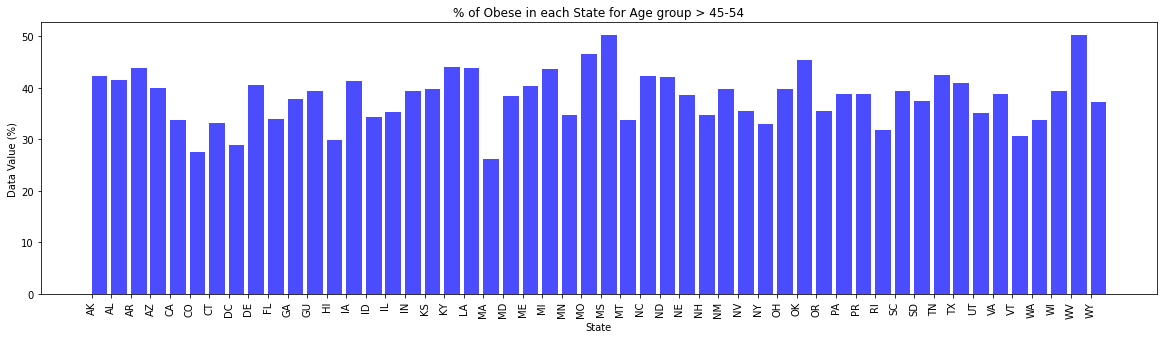

In [46]:
f = plt.figure() 
f.set_figwidth(20) 
f.set_figheight(5)
plt.bar(cls_df2['State'],cls_df2['Data Value'], color='b', alpha=0.7, align='edge')
plt.xticks(rotation='vertical')
plt.xlabel("State")
plt.ylabel("Data Value (%)")
plt.title('% of Obese in each State for Age group > 45-54')
plt.show()

In [47]:
cls_df3 = yr2019.loc[yr2019['Class'] == '18-24']
cls_df3

,Year,State,BMI,Class,Class Category,Data Value,Lower Limit,Higher Limit
17,2019,AK,Obese (BMI 30.0 - 99.8),18-24,Age Group,15.44,7.87,23.01
181,2019,AL,Obese (BMI 30.0 - 99.8),18-24,Age Group,24.62,19.03,30.21
288,2019,AR,Obese (BMI 30.0 - 99.8),18-24,Age Group,26.29,19.18,33.40
331,2019,AZ,Obese (BMI 30.0 - 99.8),18-24,Age Group,20.05,14.66,25.44
425,2019,CA,Obese (BMI 30.0 - 99.8),18-24,Age Group,13.15,10.58,15.72
547,2019,CO,Obese (BMI 30.0 - 99.8),18-24,Age Group,12.02,9.10,14.94
705,2019,CT,Obese (BMI 30.0 - 99.8),18-24,Age Group,18.06,13.38,22.74
820,2019,DC,Obese (BMI 30.0 - 99.8),18-24,Age Group,12.94,6.59,19.29
934,2019,DE,Obese (BMI 30.0 - 99.8),18-24,Age Group,22.95,15.50,30.40
1012,2019,FL,Obese (BMI 30.0 - 99.8),18-24,Age Group,15.44,11.46,19.42


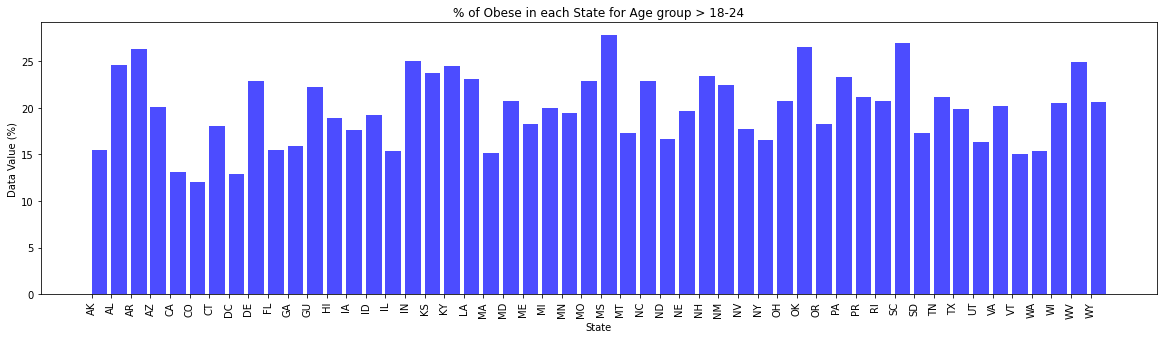

In [48]:
f = plt.figure() 
f.set_figwidth(20) 
f.set_figheight(5)
plt.bar(cls_df3['State'],cls_df3['Data Value'], color='b', alpha=0.7, align='edge')
plt.xticks(rotation='vertical')
plt.xlabel("State")
plt.ylabel("Data Value (%)")
plt.title('% of Obese in each State for Age group > 18-24')
plt.show()